<a href="https://colab.research.google.com/github/VinKKAP/Introduction-to-Deep-Learning/blob/main/Introduction_to_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Lecture: Introduction to PyTorch
# https://lmy.de/mfLMK

Tuesday 26th 2024, Oliver Schacht

In todays lecture we are going to explore specific concepts of Deep Learning with ``pytorch`` more in-depth.

This tutorial notebook is inspired by the tutorials of [Philipp Lippe](https://github.com/phlippe/uvadlc_notebooks/tree/master), University of Amsterdam.

We will cover the following topics:

- Backpropagation
- GPU support
- Building a simple Neural Network
- Activation Functions
- Initialization
- Optimization

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
import torch

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

import tqdm

## Dynamic Computation Graph and Backpropagation
One of the main reasons for using PyTorch in Deep Learning projects is that we can automatically get **gradients/derivatives** of functions that we define. Computationally, neural networks are just very fancy functions we want to learn. During learning the function, the parameters to optimization target is being called the **parameters** or simply the **weights**.

If our neural network would output a single scalar value, we would talk about taking the **derivative**, but since mostly the output has **multiple** variables ("values"); in that case we talk about **gradients**. It's a more general term.

Given an input $\mathbf{x}$, we define our function by **manipulating** that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are automatically creating a **computational graph**. This graph shows how to arrive at our output from our input.

The cool thing is: If we can compute the **output**, then we can ask PyTorch to automatically to get the **gradients**.

> **Why do we want gradients?** Consider that we have defined a function, a neural net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.

The first thing we have to do is to specify which tensors require gradients. By default, when we create a tensor, it does not require gradients.

In [2]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()` (underscore indicating that this is a in-place operation). Alternatively, when creating a tensor, you can pass the argument `requires_grad=True` to most initializers we have seen above.

In [3]:
x.requires_grad_(True)
print(x.requires_grad)

True


In order to get familiar with the concept of a computation graph, we will create one for the following function:

$$y = \frac{1}{\ell(x)}\sum_i \left[(x_i + 2)^2 + 3\right],$$

where we use $\ell(x)$ to denote the number of elements in $x$. In other words, we are taking a mean here over the operation within the sum. You could imagine that $x$ are our parameters, and we want to optimize (either maximize or minimize) the output $y$. For this, we want to obtain the gradients $\partial y / \partial \mathbf{x}$. For our example, we'll use $\mathbf{x}=[0,1,2]$ as our input.

In [4]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


Now let's build the computation graph step by step. You can combine multiple operations in a single line, but we will separate them here to get a better understanding of how each operation is added to the computation graph.

In [5]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


We calculate $a$ based on the inputs $x$ and the constant $2$, $b$ is $a$ squared, and so on. The visualization is an abstraction of the dependencies between inputs and outputs of the operations we have applied.
Each node of the computation graph has automatically defined a function for calculating the gradients with respect to its inputs, `grad_fn`. You can see this when we printed the output tensor $y$. This is why the computation graph is usually visualized in the reverse direction (arrows point from the result to the inputs). We can perform backpropagation on the computation graph by calling the function `backward()` on the last output, which effectively calculates the gradients for each tensor that has the property `requires_grad=True`:

In [6]:
y.backward()

`x.grad` will now contain the gradient $\partial y/ \partial \mathcal{x}$, and this gradient indicates how a change in $\mathbf{x}$ will affect output $y$ given the current input $\mathbf{x}=[0,1,2]$:

In [7]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


### Excursion: Why use GPU?

A crucial feature of PyTorch is the support of GPUs, short for Graphics Processing Unit. A GPU can perform many thousands of small operations in parallel, making it very well suitable for performing large matrix operations in neural networks.

CPUs and GPUs have both different advantages and disadvantages, which is why many computers contain both components and use them for different tasks. In case you are not familiar with GPUs, you can read up more details in this [NVIDIA blog post](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) or [here](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html).

GPUs can accelerate the training of your network up to a factor of $100$ which is essential for large neural networks. PyTorch implements a lot of functionality for supporting GPUs (mostly those of NVIDIA due to the libraries [CUDA](https://developer.nvidia.com/cuda-zone) and [cuDNN](https://developer.nvidia.com/cudnn)). First, let's check whether you have a GPU available:

In [8]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


If you have a GPU on your computer but the command above returns False, make sure you have the correct CUDA-version installed. The `dl2024` environment comes with the CUDA 12.4, which is selected for the Snellius supercomputer. Please change it if necessary. On Google Colab, make sure that you have selected a GPU in your runtime setup (in the menu, check under `Runtime -> Change runtime type`).

By default, all tensors you create are stored on the CPU. We can push a tensor to the GPU by using the function `.to(...)`, or `.cuda()`. However, it is often a good practice to define a `device` object in your code which points to the GPU if you have one, and otherwise to the CPU. Then, you can write your code with respect to this device object, and it allows you to run the same code on both a CPU-only system, and one with a GPU. Let's try it below. We can specify the device as follows:

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


Now let's create a tensor and push it to the device:

In [10]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In case you have a GPU, you should now see the attribute `device='cuda:0'` being printed next to your tensor. The zero next to cuda indicates that this is the zero-th GPU device on your computer. PyTorch also supports multi-GPU systems.

We can also compare the runtime of a large matrix multiplication on the CPU with a operation on the GPU:

In [11]:
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 2.58336s
GPU time: 0.08762s


Depending on the size of the operation and the CPU/GPU in your system, the speedup of this operation can be >50x. As `matmul` operations are very common in neural networks, we can already see the great benefit of training a NN on a GPU.

When generating random numbers, the seed between CPU and GPU is not synchronized. Hence, we need to set the seed on the GPU separately to ensure a reproducible code. Note that due to different GPU architectures, running the same code on different GPUs does not guarantee the same random numbers. Still, we don't want that our code gives us a different output every time we run it on the exact same hardware. Hence, we also set the seed on the GPU:

In [12]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Training a Network: Continuous XOR

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get complicated if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient.

To introduce the workflow of training a network in PyTorch, we use a simple example classifier on a simple yet well known example: XOR. Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. T
To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

<center style="width: 100%"><img src="https://raw.githubusercontent.com/phlippe/uvadlc_notebooks/940b2312f241cf8e0b6c2c59ae0acdadf0f7d902/docs/tutorial_notebooks/tutorial2/continuous_xor.svg" width="350px"></center>

This example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function.
Hence, we will learn how to build a small neural network that can learn this function.

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). **In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already.** We import it below:

In [13]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers. This is in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below), and `torch.nn` actually uses a lot of functionalities from `torch.nn.functional`. Hence, the functional package is useful in many situations, and so we import it as well here.

In [14]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [15]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place, and is executed when you call the module (`nn = MyModule(); nn(x)`). It is basically the opposite of `.backward()`, where we follow the computation graph along the gradients backwards. In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="https://raw.githubusercontent.com/phlippe/uvadlc_notebooks/940b2312f241cf8e0b6c2c59ae0acdadf0f7d902/docs/tutorial_notebooks/tutorial2/small_neural_network.svg" width="300px"></center>

The input neurons are shown in blue, which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in white, and the output neuron in red.
In PyTorch, we can define this as follows:

In [16]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [17]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [18]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


Each linear layer has a weight matrix of the shape `[output, input]`, and a bias of the shape `[output]`. The tanh activation function does not have any parameters. Note that parameters are only registered for `nn.Module` objects that are direct object attributes, i.e. `self.a = ...`. If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like `nn.ModuleList`, `nn.ModuleDict` and `nn.Sequential`, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there.

### Data Storage

PyTorch also provides a few functionalities to load the training and test data efficiently, summarized in the package `torch.utils.data`.

In [19]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

Dataset = storage;
Dataloader = for loading in batches, optimization

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [20]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

Let's try to create such a dataset and inspect it:

In [21]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.9135, 0.8573]), tensor(0))


To better relate to the dataset, we visualize the samples below.

In [22]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

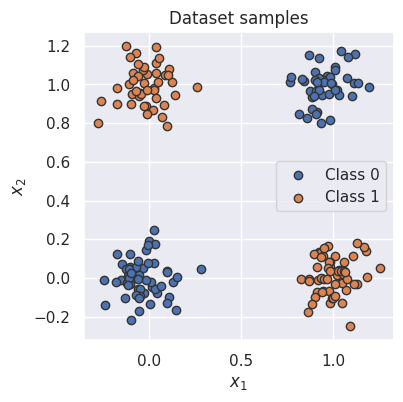

In [23]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)):

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

Let's create a simple data loader below:

In [24]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [29]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0100, -0.0937],
        [-0.0882,  1.0212],
        [-0.1120, -0.0343],
        [ 1.1146,  1.1597],
        [ 0.9115,  1.0111],
        [ 0.9454, -0.0691],
        [ 0.0364,  1.0584],
        [-0.1030, -0.0323]])
Data labels torch.Size([8]) 
 tensor([1, 1, 0, 0, 0, 1, 1, 0])


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

#### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. However, PyTorch already provides a list of predefined loss functions which we can use (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions) for a full list). For instance, for BCE, PyTorch has two modules: `nn.BCELoss()`, `nn.BCEWithLogitsLoss()`. While `nn.BCELoss` expects the inputs $x$ to be in the range $[0,1]$, i.e. the output of a sigmoid, `nn.BCEWithLogitsLoss` combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module `nn.BCEWithLogitsLoss`.

In [25]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent

For updating the parameters, PyTorch provides the package `torch.optim` that has most popular optimizers implemented. We will discuss the specific optimizers and their differences later in the course, but will for now use the simplest of them: `torch.optim.SGD`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1.

In [26]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions:

- `optimizer.step()`: The step function updates the parameters based on the gradients as explained above.
- `optimizer.zero_grad()`: The reset function sets the gradients of all parameters to zero. While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. If we call the `backward` function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them.

**Hence, remember to call `optimizer.zero_grad()` before calculating the gradients of a batch.**

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size.

In [30]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Now, we can write a small training function. Remember our five steps: load a batch, obtain the predictions, calculate the loss, backpropagate, and update. Additionally, we have to push all data and model parameters to the device of our choice (GPU if available). For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on CPU. For large networks, the communication time is significantly smaller than the actual runtime making a GPU crucial in these cases. Still, to practice, we will push the data to GPU here.

In [31]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In addition, we set our model to training mode. This is done by calling `model.train()`. There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using `model.train()` and `model.eval()`.

In [32]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [33]:
train_model(model, optimizer, train_data_loader, loss_module)

100%|██████████| 100/100 [00:04<00:00, 22.05it/s]


#### Optional: Saving the model

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called `state_dict` from the model which contains all learnable parameters. For our simple model, the state dict contains the following entries:

In [34]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 0.5428,  0.0265],
        [-2.5052, -1.2528],
        [-2.7404, -3.4792],
        [ 2.2380, -2.7380]], device='cuda:0')), ('linear1.bias', tensor([ 0.3214,  2.6102,  1.4754, -1.4310], device='cuda:0')), ('linear2.weight', tensor([[-0.7458,  4.3912, -4.7290,  3.4949]], device='cuda:0')), ('linear2.bias', tensor([-1.0282], device='cuda:0'))])


To save the state dictionary, we can use `torch.save`:

In [35]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

To load a model from a state dict, we use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [36]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 0.5428,  0.0265],
        [-2.5052, -1.2528],
        [-2.7404, -3.4792],
        [ 2.2380, -2.7380]], device='cuda:0')), ('linear1.bias', tensor([ 0.3214,  2.6102,  1.4754, -1.4310], device='cuda:0')), ('linear2.weight', tensor([[-0.7458,  4.3912, -4.7290,  3.4949]], device='cuda:0')), ('linear2.bias', tensor([-1.0282], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 0.5428,  0.0265],
        [-2.5052, -1.2528],
        [-2.7404, -3.4792],
        [ 2.2380, -2.7380]])), ('linear1.bias', tensor([ 0.3214,  2.6102,  1.4754, -1.4310])), ('linear2.weight', tensor([[-0.7458,  4.3912, -4.7290,  3.4949]])), ('linear2.bias', tensor([-1.0282]))])


<ipython-input-36-9b8ea49100fa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("our_model.tar")


A detailed tutorial on saving and loading models in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [37]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

As metric, we will use accuracy which is calculated as follows:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

where TP are the true positives, TN true negatives, FP false positives, and FN the fale negatives.

When evaluating the model, we don't need to keep track of the computation graph as we don't intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graph using `with torch.no_grad(): ...`. Remember to additionally set the model to eval mode.

In [38]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [39]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

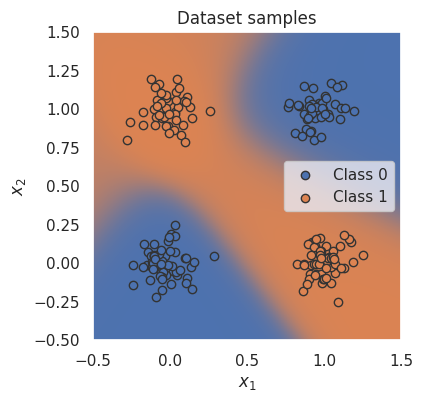

In [41]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same.

## More on Activation Functions

Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks.
There is a great variety of activation functions in the literature, and some are more beneficial than others.
We want to highlight the importance of choosing a good activation function and what problems might occur if we don't.

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `torch.nn` package (see the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview).
However, we'll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [42]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh.
Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`).
Here, we implement them by hand:

In [43]:
##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU).
Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.
Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish.
LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input.
ELU and Swish that won't be discussed in this notebook. If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941) [1].

Let's implement the two activation functions below:

In [44]:
##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [45]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following.
Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network.
PyTorch allows us to compute the gradients simply by calling the `backward` function:

In [46]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

Now we can visualize all our activation functions including their gradients:

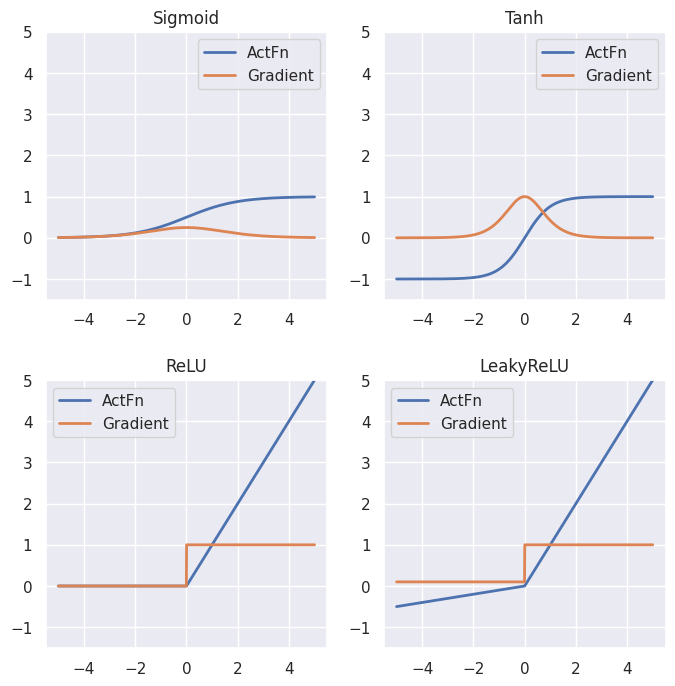

In [47]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

### Analysing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect.
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

#### Setup

Firstly, let's set up a neural network. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. Feel free to experiment with other network architectures. CNN architectures certainly would be more benefitial here albeit more complex.

In [48]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

We also set up the dataset we want to train it on, namely [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of yet another PyTorch package, namely `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling.

Let's load the dataset below, and visualize a few images to get an impression of the data.

In [49]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Path where the dataset is stored
DATASET_PATH = "./data_torch"

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]


Extracting ./data_torch/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_torch/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.21MB/s]


Extracting ./data_torch/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_torch/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 66.5MB/s]


Extracting ./data_torch/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_torch/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


Extracting ./data_torch/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_torch/FashionMNIST/raw



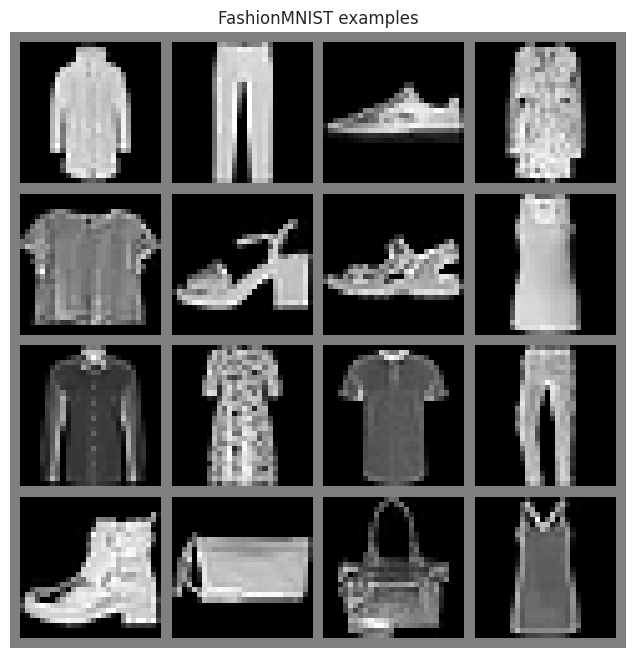

In [50]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Visualizing the gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode.

To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images:

In [51]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

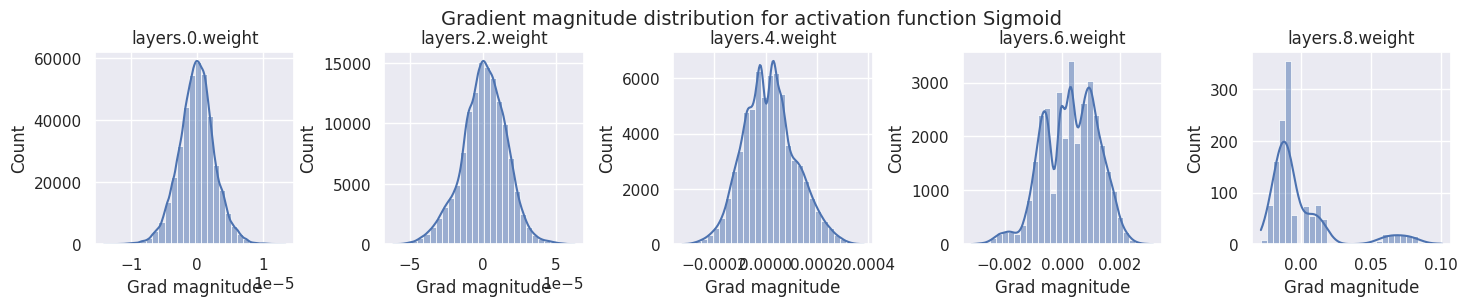

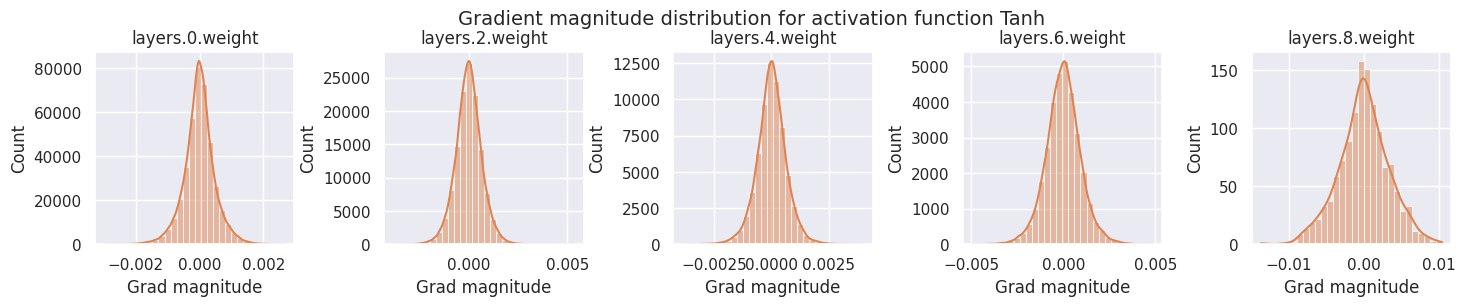

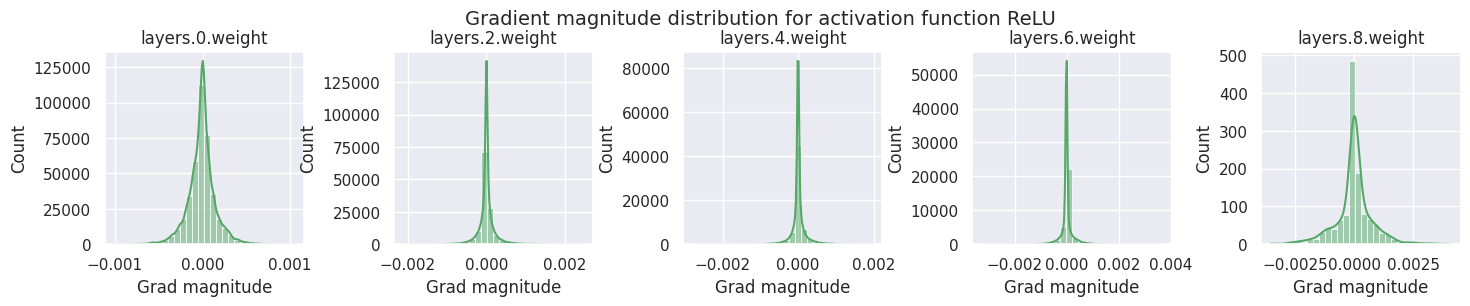

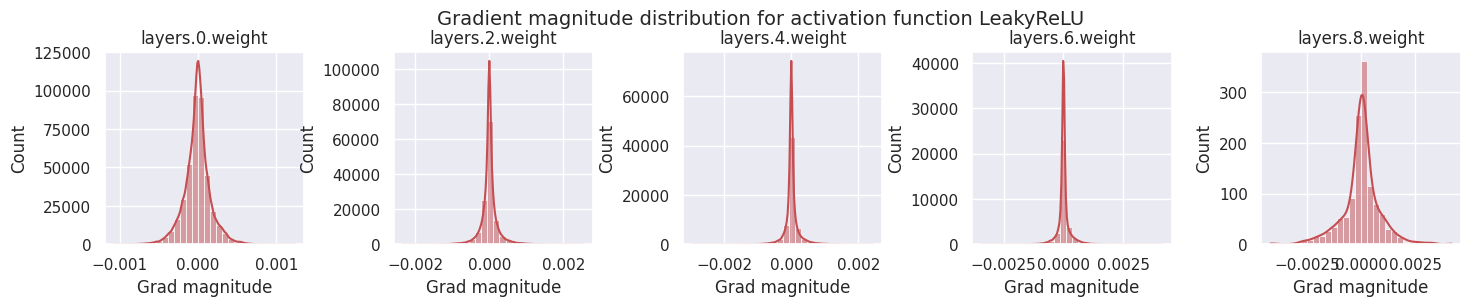

In [52]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    np.random.seed(42)
    torch.manual_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.
All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons. The issue of dead neurons is that as no gradient is provided for the layer, we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.
For dead neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all input images.
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen.

## Optimization of the FashioMNIST

Note that additionally to the activation, the initialization of the weight parameters can be crucial. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations.

When increasing the depth of neural networks, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. [This notebook](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial4/Optimization_and_Initialization.ipynb) takes a closer look at the following concepts: initialization and optimization.

We will however conclude with optimizing the FashionMNIST with SGD and the default Kaiming initialization. First, we reload the MNIST dataset.

In [53]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In comparison to above, we have changed the parameters of the normalization transformation `transforms.Normalize`. The normalization is now designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and stddev 1) have shown to work well.
We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [54]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860405743122101
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [55]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.002
Standard deviation: 1.002
Maximum: 2.022
Minimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

As activation function, we make use of PyTorch's `torch.nn.ReLU()` instead of our hand-made implementations above. From the lecture you know only one optimizer by now: Stochastic Gradient Descent (SGD). SGD updates the parameters using the following equation:

$$
\begin{split}
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

As simple as the equation is also our implementation of SGD:

In [56]:
class Selfmade_SGD:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

As the Kaiming Initialization is the default, we don't need to implement something here. And directly continue with a training function for our neural network.

In [58]:
def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
    """

    # Defining optimizer, loss and data loader
    optimizer =  optim_func(net.parameters())
    loss_module = nn.CrossEntropyLoss()
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    results = None
    val_scores = []
    train_losses, train_scores = [], []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        ############
        # Training #
        ############
        net.train()
        true_preds, count = 0., 0
        t = tqdm.tqdm(train_loader_local, leave=False)
        for imgs, labels in t:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = net(imgs)
            loss = loss_module(preds, labels)
            loss.backward()
            optimizer.step()
            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum().item()
            count += labels.shape[0]
            t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
            train_losses.append(loss.item())
        train_acc = true_preds / count
        train_scores.append(train_acc)

        ##############
        # Validation #
        ##############
        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

    test_acc = test_model(net, test_loader)
    results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results

The test function uses unseen data to evaluate the network out of sample

In [59]:
def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

We can train the network and look at a few epochs.

[Epoch  1] Training accuracy: 59.06%, Validation accuracy: 77.45%


[Epoch  2] Training accuracy: 80.20%, Validation accuracy: 81.54%


[Epoch  3] Training accuracy: 83.52%, Validation accuracy: 85.35%


[Epoch  4] Training accuracy: 85.13%, Validation accuracy: 85.12%


[Epoch  5] Training accuracy: 86.40%, Validation accuracy: 86.60%


[Epoch  6] Training accuracy: 87.36%, Validation accuracy: 86.93%


[Epoch  7] Training accuracy: 87.90%, Validation accuracy: 87.26%


[Epoch  8] Training accuracy: 88.49%, Validation accuracy: 88.09%


[Epoch  9] Training accuracy: 88.97%, Validation accuracy: 86.59%


[Epoch 10] Training accuracy: 89.57%, Validation accuracy: 86.64%


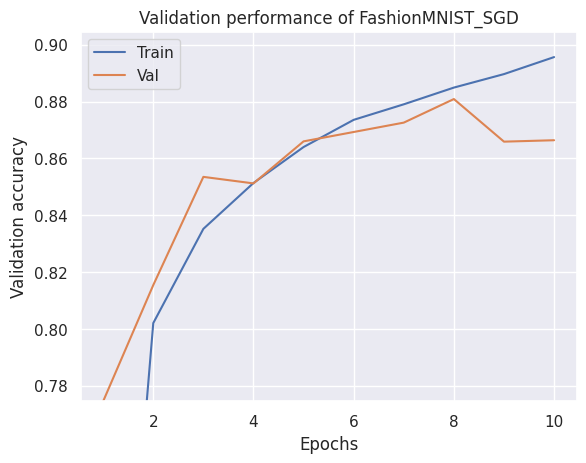

============= Test accuracy: 85.43% ==============



In [60]:
import copy

base_model = BaseNetwork(act_fn=ReLU(), hidden_sizes=[512,256,256,128])
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD",
                          lambda params: Selfmade_SGD(params, lr=1e-1),
                          max_epochs=10, batch_size=256)

## Still motivated?

Here are some things you might want to look at as excercise for at home:

- Repeat XOR example with `sklearn.linear_model.LogisticRegressionCV()` to proof that it fails on this task. :)
- Repeat the FashionMNIST example as a custom convolutional neural network. Can you increase performance?
- Dropout and Weight Decay: Remember the concept of over- and underfitting? To avoid it, we could add these techniques to the FashionMNIST example. Does it improve the performance?
- Use an implementation of ResNet from `torchvision.models.resnet` for FashionMNIST